In [1]:
from itertools import product
import calendar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, f1_score

<a id='wrangling'></a>
## Data Wrangling

In this section we'll load the data, assess it to check for any quality or tidiness issues and clean where needed.

<a id='gather'></a>
### Gather

In [3]:
df = pd.read_csv('../data/consolidated_coin_data.csv')

In [4]:
df.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,ripple,"Apr 24, 2019",0.321114,0.321282,0.296982,0.302318,"1,517,791,002","12,698,877,293"
1,ripple,"Apr 23, 2019",0.323844,0.328396,0.320919,0.321222,"1,077,333,990","13,492,933,875"
2,ripple,"Apr 22, 2019",0.322277,0.329350,0.320237,0.323934,"1,131,094,080","13,606,823,301"
3,ripple,"Apr 21, 2019",0.328678,0.329627,0.318746,0.322449,"1,005,803,846","13,533,407,430"
4,ripple,"Apr 20, 2019",0.331871,0.333213,0.324969,0.328476,"931,570,799","13,786,384,592"


In [5]:
df = df.copy()[df["Currency"] == 'bitcoin']

<a id='assess'></a>
### Assess

In [6]:
df.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
3392,bitcoin,"Apr 24, 2019",5571.51,5642.04,5418.26,5464.87,"17,048,033,399","96,530,038,144"
3393,bitcoin,"Apr 23, 2019",5399.37,5633.80,5389.41,5572.36,"15,867,308,108","98,417,387,004"
3394,bitcoin,"Apr 22, 2019",5312.49,5422.69,5280.28,5399.37,"14,601,631,648","95,354,207,776"
3395,bitcoin,"Apr 21, 2019",5335.88,5359.93,5257.34,5314.53,"13,731,844,223","93,847,052,256"
3396,bitcoin,"Apr 20, 2019",5304.16,5358.49,5295.88,5337.89,"13,169,647,522","94,248,717,444"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2188 entries, 3392 to 5579
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Currency    2188 non-null   object 
 1   Date        2188 non-null   object 
 2   Open        2188 non-null   float64
 3   High        2188 non-null   float64
 4   Low         2188 non-null   float64
 5   Close       2188 non-null   float64
 6   Volume      2188 non-null   object 
 7   Market Cap  2188 non-null   object 
dtypes: float64(4), object(4)
memory usage: 153.8+ KB


In [8]:
df.tail()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
5575,bitcoin,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,168,517,495"
5576,bitcoin,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,298,954,594"
5577,bitcoin,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,542,813,125"
5578,bitcoin,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,603,768,865"
5579,bitcoin,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,488,566,728"


In [9]:
df["Volume"].value_counts()

-                243
266,392,992        1
6,491,120,128      1
7,922,070          1
28,153,700         1
                ... 
42,744,400         1
283,320,000        1
81,673,104         1
45,580,900         1
46,422,400         1
Name: Volume, Length: 1946, dtype: int64

- Date is not a Date Object
- Volume and Market Cap are strings and not ints
- Columns start with capital letters and have spaces
- Dates are decreasing
- Volume column has invalid caracters

<a id='clean'></a>
### Clean

**- Columns start with capital letters and have spaces**

In [10]:
df.rename(columns={col: col.lower().replace(" ", "_") for col in df.columns}, inplace=True)

In [11]:
df.head()

,currency,date,open,high,low,close,volume,market_cap
3392,bitcoin,"Apr 24, 2019",5571.51,5642.04,5418.26,5464.87,"17,048,033,399","96,530,038,144"
3393,bitcoin,"Apr 23, 2019",5399.37,5633.80,5389.41,5572.36,"15,867,308,108","98,417,387,004"
3394,bitcoin,"Apr 22, 2019",5312.49,5422.69,5280.28,5399.37,"14,601,631,648","95,354,207,776"
3395,bitcoin,"Apr 21, 2019",5335.88,5359.93,5257.34,5314.53,"13,731,844,223","93,847,052,256"
3396,bitcoin,"Apr 20, 2019",5304.16,5358.49,5295.88,5337.89,"13,169,647,522","94,248,717,444"


**- Volume column has invalid caracters**<br>
**- Volume and Market Cap are strings and not ints**

In [12]:
def convert_to_float(string_number):
    try:
        string_number = string_number.replace(',', '')
        string_number = float(string_number)
    except AttributeError:
        pass
    return string_number
    

In [13]:
df["volume"] = df["volume"].replace('-', np.nan)

In [14]:
df["volume"] = df["volume"].apply(convert_to_float)

In [15]:
df["market_cap"] = df["market_cap"].apply(convert_to_float)

In [16]:
df.head()

,currency,date,open,high,low,close,volume,market_cap
3392,bitcoin,"Apr 24, 2019",5571.51,5642.04,5418.26,5464.87,1.704803e+10,9.653004e+10
3393,bitcoin,"Apr 23, 2019",5399.37,5633.80,5389.41,5572.36,1.586731e+10,9.841739e+10
3394,bitcoin,"Apr 22, 2019",5312.49,5422.69,5280.28,5399.37,1.460163e+10,9.535421e+10
3395,bitcoin,"Apr 21, 2019",5335.88,5359.93,5257.34,5314.53,1.373184e+10,9.384705e+10
3396,bitcoin,"Apr 20, 2019",5304.16,5358.49,5295.88,5337.89,1.316965e+10,9.424872e+10


In [17]:
df.tail()

,currency,date,open,high,low,close,volume,market_cap
5575,bitcoin,"May 02, 2013",116.38,125.60,92.28,105.21,NaN,1.168517e+09
5576,bitcoin,"May 01, 2013",139.00,139.89,107.72,116.99,NaN,1.298955e+09
5577,bitcoin,"Apr 30, 2013",144.00,146.93,134.05,139.00,NaN,1.542813e+09
5578,bitcoin,"Apr 29, 2013",134.44,147.49,134.00,144.54,NaN,1.603769e+09
5579,bitcoin,"Apr 28, 2013",135.30,135.98,132.10,134.21,NaN,1.488567e+09


**- Date is not a Date Object**

In [18]:
df.date = pd.to_datetime(df.date, format='%b %d, %Y', errors='ignore')

In [19]:
df.head()

,currency,date,open,high,low,close,volume,market_cap
3392,bitcoin,2019-04-24,5571.51,5642.04,5418.26,5464.87,1.704803e+10,9.653004e+10
3393,bitcoin,2019-04-23,5399.37,5633.80,5389.41,5572.36,1.586731e+10,9.841739e+10
3394,bitcoin,2019-04-22,5312.49,5422.69,5280.28,5399.37,1.460163e+10,9.535421e+10
3395,bitcoin,2019-04-21,5335.88,5359.93,5257.34,5314.53,1.373184e+10,9.384705e+10
3396,bitcoin,2019-04-20,5304.16,5358.49,5295.88,5337.89,1.316965e+10,9.424872e+10


**- Dates are decreasing**

In [20]:
df = df.sort_values(by='date').reset_index()

In [21]:
df.head()

,index,currency,date,open,high,low,close,volume,market_cap
0,5579,bitcoin,2013-04-28,135.30,135.98,132.10,134.21,NaN,1.488567e+09
1,5578,bitcoin,2013-04-29,134.44,147.49,134.00,144.54,NaN,1.603769e+09
2,5577,bitcoin,2013-04-30,144.00,146.93,134.05,139.00,NaN,1.542813e+09
3,5576,bitcoin,2013-05-01,139.00,139.89,107.72,116.99,NaN,1.298955e+09
4,5575,bitcoin,2013-05-02,116.38,125.60,92.28,105.21,NaN,1.168517e+09


<a id='feature_engineering'></a>
## Feature Engineering

In [22]:
df["change"] = (df["close"] - df["open"]) / df["open"] 

In [23]:
df.head()

,index,currency,date,open,high,low,close,volume,market_cap,change
0,5579,bitcoin,2013-04-28,135.30,135.98,132.10,134.21,NaN,1.488567e+09,-0.008056
1,5578,bitcoin,2013-04-29,134.44,147.49,134.00,144.54,NaN,1.603769e+09,0.075126
2,5577,bitcoin,2013-04-30,144.00,146.93,134.05,139.00,NaN,1.542813e+09,-0.034722
3,5576,bitcoin,2013-05-01,139.00,139.89,107.72,116.99,NaN,1.298955e+09,-0.158345
4,5575,bitcoin,2013-05-02,116.38,125.60,92.28,105.21,NaN,1.168517e+09,-0.095979


In [24]:
df["change_perc"] = df["change"] * 100

In [25]:
df["number_coins"] = df["market_cap"] / df["close"]

In [26]:
df.head()

,index,currency,date,open,high,low,close,volume,market_cap,change,change_perc,number_coins
0,5579,bitcoin,2013-04-28,135.30,135.98,132.10,134.21,NaN,1.488567e+09,-0.008056,-0.805617,1.109132e+07
1,5578,bitcoin,2013-04-29,134.44,147.49,134.00,144.54,NaN,1.603769e+09,0.075126,7.512645,1.109568e+07
2,5577,bitcoin,2013-04-30,144.00,146.93,134.05,139.00,NaN,1.542813e+09,-0.034722,-3.472222,1.109938e+07
3,5576,bitcoin,2013-05-01,139.00,139.89,107.72,116.99,NaN,1.298955e+09,-0.158345,-15.834532,1.110313e+07
4,5575,bitcoin,2013-05-02,116.38,125.60,92.28,105.21,NaN,1.168517e+09,-0.095979,-9.597869,1.110652e+07


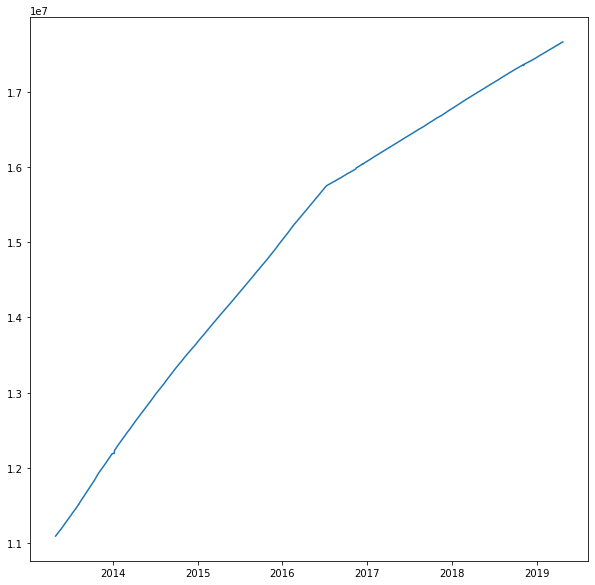

In [27]:
plt.figure(figsize=(10, 10))
plt.plot(df['date'], df['number_coins'])

In [28]:
df['close_sma_7'] = df["close"].rolling(window=7).mean()
df['close_sma_25'] = df["close"].rolling(window=25).mean()
df['close_sma_99'] = df["close"].rolling(window=99).mean()

In [29]:
df.tail(10)

,index,currency,date,open,high,low,close,volume,market_cap,change,change_perc,number_coins,close_sma_7,close_sma_25,close_sma_99
2178,3401,bitcoin,2019-04-15,5167.32,5196.61,5024.07,5067.11,1.229016e+10,8.942224e+10,-0.019393,-1.939303,1.764758e+07,5144.994286,4641.2296,3980.511111
2179,3400,bitcoin,2019-04-16,5066.58,5238.95,5055.19,5235.56,1.161866e+10,9.240461e+10,0.033352,3.335189,1.764942e+07,5149.365714,4689.6932,3992.736465
2180,3399,bitcoin,2019-04-17,5236.14,5274.28,5219.21,5251.94,1.243848e+10,9.270262e+10,0.003017,0.301749,1.765112e+07,5138.992857,4738.3376,4005.070707
2181,3398,bitcoin,2019-04-18,5251.48,5319.99,5250.51,5298.39,1.325649e+10,9.353240e+10,0.008933,0.893272,1.765299e+07,5172.407143,4789.3864,4017.829192
2182,3397,bitcoin,2019-04-19,5298.15,5336.68,5233.34,5303.81,1.378024e+10,9.363835e+10,0.001068,0.106830,1.765492e+07,5203.017143,4843.0160,4034.242222
2183,3396,bitcoin,2019-04-20,5304.16,5358.49,5295.88,5337.89,1.316965e+10,9.424872e+10,0.006359,0.635916,1.765655e+07,5237.488571,4897.1284,4050.914141
2184,3395,bitcoin,2019-04-21,5335.88,5359.93,5257.34,5314.53,1.373184e+10,9.384705e+10,-0.004001,-0.400121,1.765858e+07,5258.461429,4946.2268,4067.613434
2185,3394,bitcoin,2019-04-22,5312.49,5422.69,5280.28,5399.37,1.460163e+10,9.535421e+10,0.016354,1.635391,1.766025e+07,5305.927143,4999.4372,4086.264141
2186,3393,bitcoin,2019-04-23,5399.37,5633.80,5389.41,5572.36,1.586731e+10,9.841739e+10,0.032039,3.203892,1.766171e+07,5354.041429,5058.3968,4105.115758
2187,3392,bitcoin,2019-04-24,5571.51,5642.04,5418.26,5464.87,1.704803e+10,9.653004e+10,-0.019140,-1.914023,1.766374e+07,5384.460000,5112.7252,4123.642929


In [30]:
df.columns

Index(['index', 'currency', 'date', 'open', 'high', 'low', 'close', 'volume',
       'market_cap', 'change', 'change_perc', 'number_coins', 'close_sma_7',
       'close_sma_25', 'close_sma_99'],
      dtype='object')

In [31]:
df['close_ema'] = df["close"].ewm(com=0.5, adjust=False).mean()

In [32]:
df.tail(10)

,index,currency,date,open,high,low,close,volume,market_cap,change,change_perc,number_coins,close_sma_7,close_sma_25,close_sma_99,close_ema
2178,3401,bitcoin,2019-04-15,5167.32,5196.61,5024.07,5067.11,1.229016e+10,8.942224e+10,-0.019393,-1.939303,1.764758e+07,5144.994286,4641.2296,3980.511111,5093.095832
2179,3400,bitcoin,2019-04-16,5066.58,5238.95,5055.19,5235.56,1.161866e+10,9.240461e+10,0.033352,3.335189,1.764942e+07,5149.365714,4689.6932,3992.736465,5188.071944
2180,3399,bitcoin,2019-04-17,5236.14,5274.28,5219.21,5251.94,1.243848e+10,9.270262e+10,0.003017,0.301749,1.765112e+07,5138.992857,4738.3376,4005.070707,5230.650648
2181,3398,bitcoin,2019-04-18,5251.48,5319.99,5250.51,5298.39,1.325649e+10,9.353240e+10,0.008933,0.893272,1.765299e+07,5172.407143,4789.3864,4017.829192,5275.810216
2182,3397,bitcoin,2019-04-19,5298.15,5336.68,5233.34,5303.81,1.378024e+10,9.363835e+10,0.001068,0.106830,1.765492e+07,5203.017143,4843.0160,4034.242222,5294.476739
2183,3396,bitcoin,2019-04-20,5304.16,5358.49,5295.88,5337.89,1.316965e+10,9.424872e+10,0.006359,0.635916,1.765655e+07,5237.488571,4897.1284,4050.914141,5323.418913
2184,3395,bitcoin,2019-04-21,5335.88,5359.93,5257.34,5314.53,1.373184e+10,9.384705e+10,-0.004001,-0.400121,1.765858e+07,5258.461429,4946.2268,4067.613434,5317.492971
2185,3394,bitcoin,2019-04-22,5312.49,5422.69,5280.28,5399.37,1.460163e+10,9.535421e+10,0.016354,1.635391,1.766025e+07,5305.927143,4999.4372,4086.264141,5372.077657
2186,3393,bitcoin,2019-04-23,5399.37,5633.80,5389.41,5572.36,1.586731e+10,9.841739e+10,0.032039,3.203892,1.766171e+07,5354.041429,5058.3968,4105.115758,5505.599219
2187,3392,bitcoin,2019-04-24,5571.51,5642.04,5418.26,5464.87,1.704803e+10,9.653004e+10,-0.019140,-1.914023,1.766374e+07,5384.460000,5112.7252,4123.642929,5478.446406


In [33]:
df['volume_sma_7'] = df["volume"].rolling(window=7).mean()
df['volume_sma_25'] = df["volume"].rolling(window=25).mean()
df['volume_sma_99'] = df["volume"].rolling(window=99).mean()

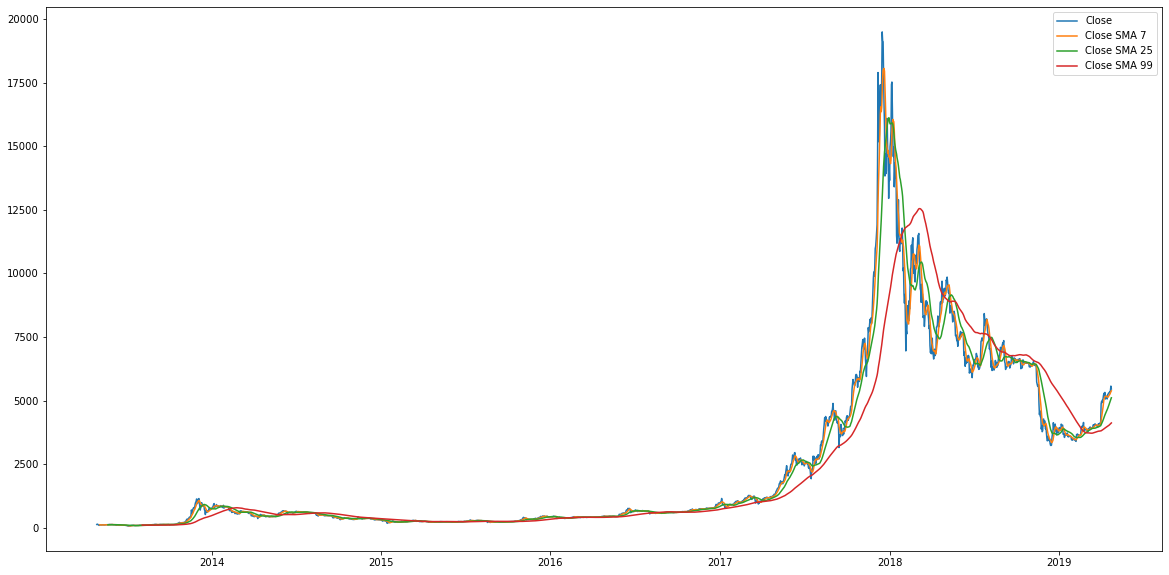

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(df["date"], df["close"], label='Close')
plt.plot(df["date"], df["close_sma_7"], label='Close SMA 7')
plt.plot(df["date"], df["close_sma_25"], label='Close SMA 25')
plt.plot(df["date"], df["close_sma_99"], label='Close SMA 99')
plt.legend()

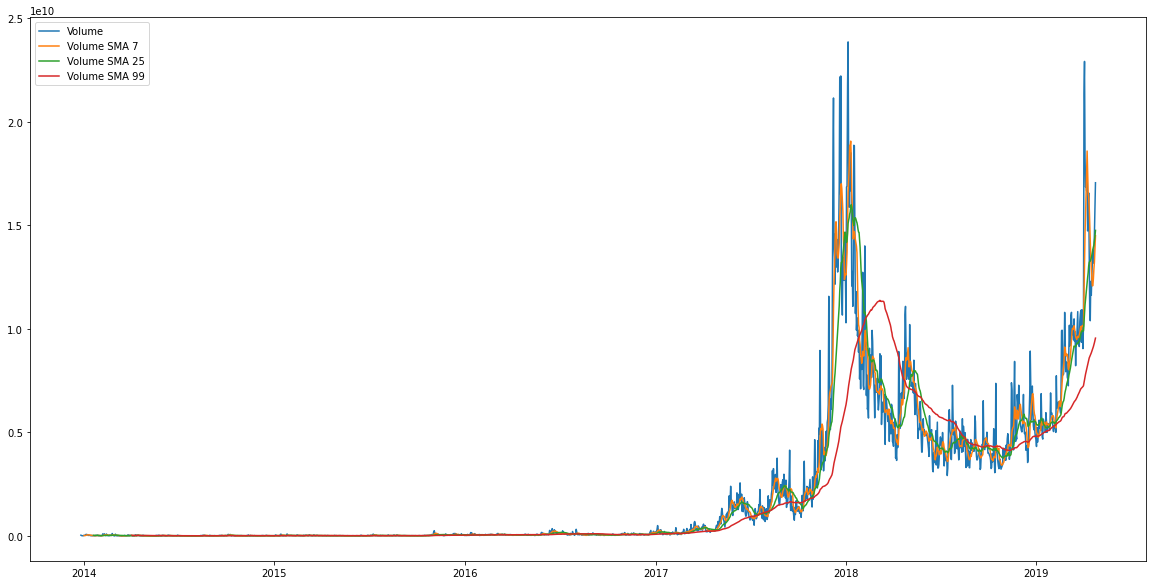

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(df["date"], df["volume"], label='Volume')
plt.plot(df["date"], df["volume_sma_7"], label='Volume SMA 7')
plt.plot(df["date"], df["volume_sma_25"], label='Volume SMA 25')
plt.plot(df["date"], df["volume_sma_99"], label='Volume SMA 99')
plt.legend()

In [36]:
df['close_smsd_7'] = df["close"].rolling(window=7).std()
df['close_smsd_25'] = df["close"].rolling(window=25).std()
df['close_smsd_99'] = df["close"].rolling(window=99).std()

In [37]:
df.tail()

,index,currency,date,open,high,low,close,volume,market_cap,change,...,close_sma_7,close_sma_25,close_sma_99,close_ema,volume_sma_7,volume_sma_25,volume_sma_99,close_smsd_7,close_smsd_25,close_smsd_99
2183,3396,bitcoin,2019-04-20,5304.16,5358.49,5295.88,5337.89,1.316965e+10,9.424872e+10,0.006359,...,5237.488571,4897.1284,4050.914141,5323.418913,1.242080e+10,1.393501e+10,9.142131e+09,93.360446,470.855369,573.622894
2184,3395,bitcoin,2019-04-21,5335.88,5359.93,5257.34,5314.53,1.373184e+10,9.384705e+10,-0.004001,...,5258.461429,4946.2268,4067.613434,5317.492971,1.289793e+10,1.404839e+10,9.232572e+09,91.547565,446.219203,586.093554
2185,3394,bitcoin,2019-04-22,5312.49,5422.69,5280.28,5399.37,1.460163e+10,9.535421e+10,0.016354,...,5305.927143,4999.4372,4086.264141,5372.077657,1.322814e+10,1.425830e+10,9.332777e+09,54.397669,415.526727,598.789716
2186,3393,bitcoin,2019-04-23,5399.37,5633.80,5389.41,5572.36,1.586731e+10,9.841739e+10,0.032039,...,5354.041429,5058.3968,4105.115758,5505.599219,1.383509e+10,1.445625e+10,9.435968e+09,106.132527,385.860059,615.833178
2187,3392,bitcoin,2019-04-24,5571.51,5642.04,5418.26,5464.87,1.704803e+10,9.653004e+10,-0.019140,...,5384.460000,5112.7252,4123.642929,5478.446406,1.449360e+10,1.474886e+10,9.552239e+09,102.441791,339.051360,628.866889


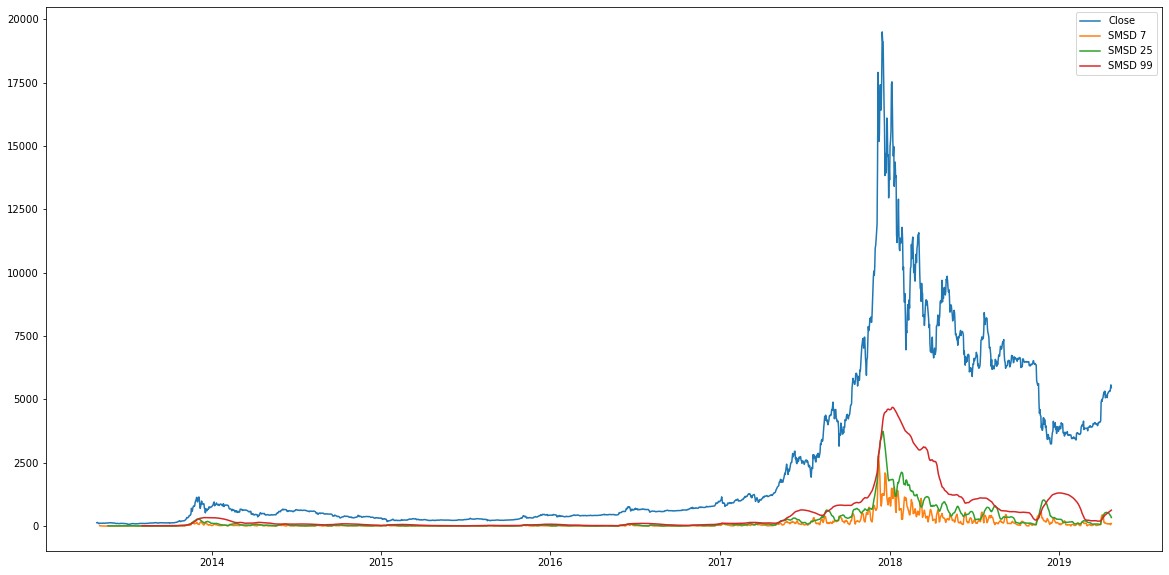

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(df["date"], df["close"], label='Close')
plt.plot(df["date"], df["close_smsd_7"], label='SMSD 7')
plt.plot(df["date"], df["close_smsd_25"], label='SMSD 25')
plt.plot(df["date"], df["close_smsd_99"], label='SMSD 99')
plt.legend()

In [39]:
# calculate Simple Moving Average with 20 days window
sma = df["close"].rolling(window=99).mean()

# calculate the standar deviation
rstd = df["close"].rolling(window=99).std()

In [40]:
df["upper"] = sma + 2 * rstd
df["lower"] = sma - 2 * rstd

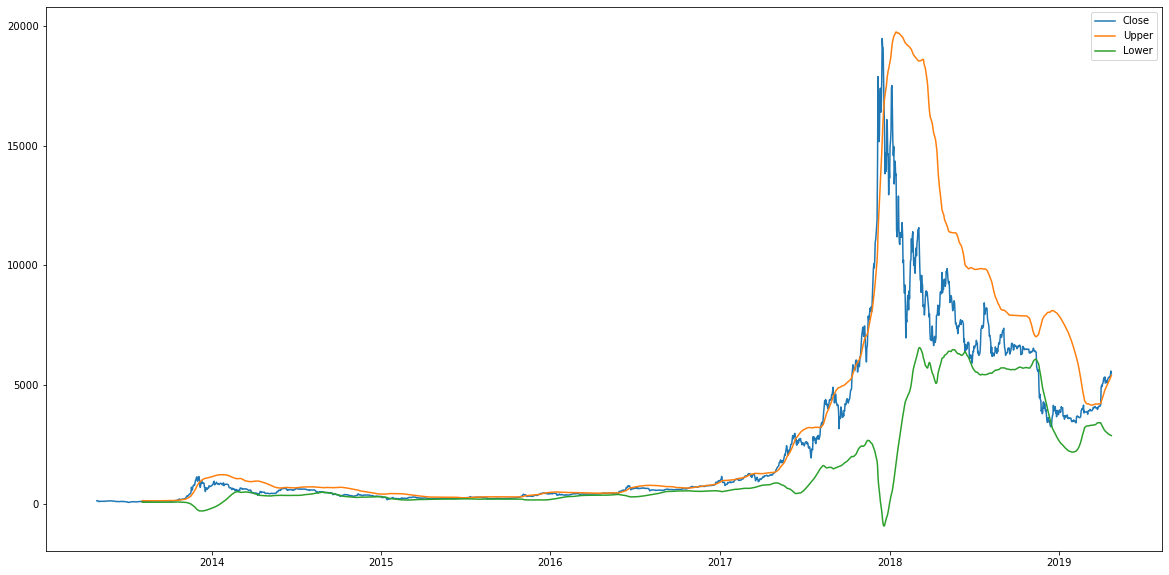

In [41]:
plt.figure(figsize=(20, 10))
plt.plot(df["date"], df["close"], label='Close')
plt.plot(df["date"], df["upper"], label='Upper')
plt.plot(df["date"], df["lower"], label='Lower')
plt.legend()

In [42]:
df["volatility"] = (df["high"] - df["low"]) / df["high"]

In [43]:
df

,index,currency,date,open,high,low,close,volume,market_cap,change,...,close_ema,volume_sma_7,volume_sma_25,volume_sma_99,close_smsd_7,close_smsd_25,close_smsd_99,upper,lower,volatility
0,5579,bitcoin,2013-04-28,135.30,135.98,132.10,134.21,NaN,1.488567e+09,-0.008056,...,134.210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028534
1,5578,bitcoin,2013-04-29,134.44,147.49,134.00,144.54,NaN,1.603769e+09,0.075126,...,141.096667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091464
2,5577,bitcoin,2013-04-30,144.00,146.93,134.05,139.00,NaN,1.542813e+09,-0.034722,...,139.698889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087661
3,5576,bitcoin,2013-05-01,139.00,139.89,107.72,116.99,NaN,1.298955e+09,-0.158345,...,124.559630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229966
4,5575,bitcoin,2013-05-02,116.38,125.60,92.28,105.21,NaN,1.168517e+09,-0.095979,...,111.659877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.265287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,3396,bitcoin,2019-04-20,5304.16,5358.49,5295.88,5337.89,1.316965e+10,9.424872e+10,0.006359,...,5323.418913,1.242080e+10,1.393501e+10,9.142131e+09,93.360446,470.855369,573.622894,5198.159929,2903.668354,0.011684
2184,3395,bitcoin,2019-04-21,5335.88,5359.93,5257.34,5314.53,1.373184e+10,9.384705e+10,-0.004001,...,5317.492971,1.289793e+10,1.404839e+10,9.232572e+09,91.547565,446.219203,586.093554,5239.800542,2895.426327,0.019140
2185,3394,bitcoin,2019-04-22,5312.49,5422.69,5280.28,5399.37,1.460163e+10,9.535421e+10,0.016354,...,5372.077657,1.322814e+10,1.425830e+10,9.332777e+09,54.397669,415.526727,598.789716,5283.843573,2888.684710,0.026262
2186,3393,bitcoin,2019-04-23,5399.37,5633.80,5389.41,5572.36,1.586731e+10,9.841739e+10,0.032039,...,5505.599219,1.383509e+10,1.445625e+10,9.435968e+09,106.132527,385.860059,615.833178,5336.782113,2873.449402,0.043379


In [44]:
df["target"] = df["change"].shift(-1)

In [45]:
df[["target", "change"]]

,target,change
0,0.075126,-0.008056
1,-0.034722,0.075126
2,-0.158345,-0.034722
3,-0.095979,-0.158345
4,-0.080000,-0.095979
...,...,...
2183,-0.004001,0.006359
2184,0.016354,-0.004001
2185,0.032039,0.016354
2186,-0.019140,0.032039


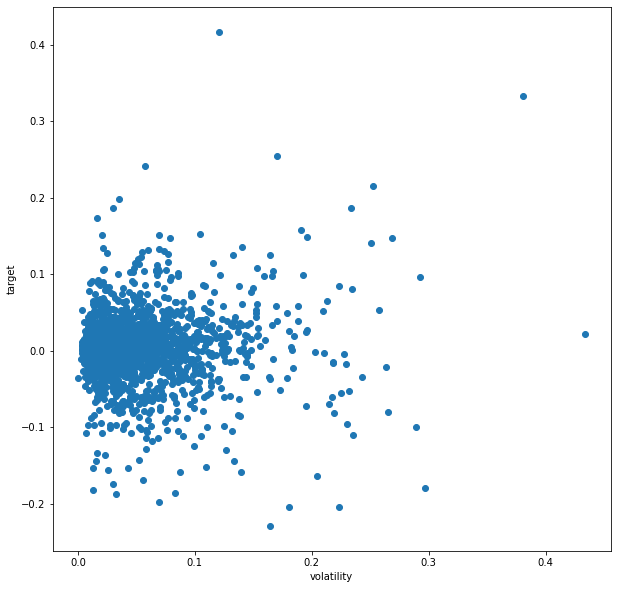

In [46]:
variable = 'volatility'

plt.figure(figsize=(10, 10))
plt.scatter(data=df, x=variable, y='target')
plt.xlabel(variable);
plt.ylabel('target');

ValueError: x and y must be the same size

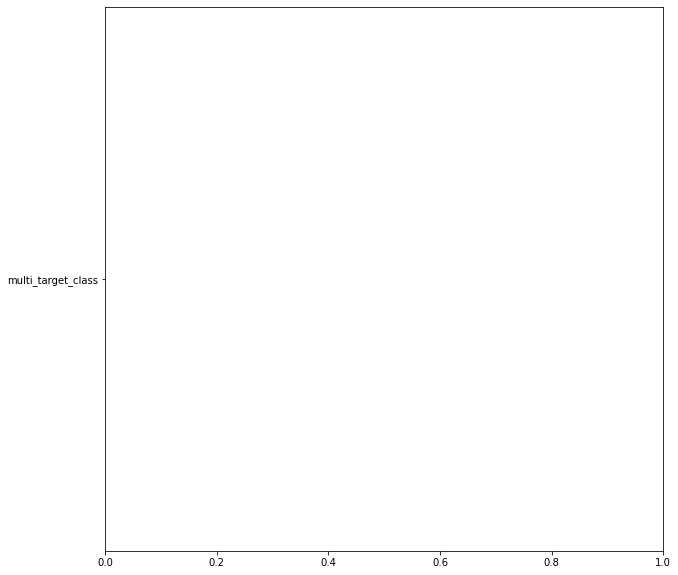

In [47]:
variable = 'volatility'

plt.figure(figsize=(10, 10))
plt.scatter(data=df, x=variable, y='multi_target_class')
plt.xlabel(variable);
plt.ylabel('target');

In [ ]:
variable = 'volume_sma_7'

plt.figure(figsize=(10, 10))
plt.scatter(data=df, x=variable, y='target')
plt.xlabel(variable);
plt.ylabel('target');

In [ ]:
df["target_class"] = df.target.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
threshold = 0.007

def compute_class(element):
    if element > threshold:
        return 1
    elif element < -threshold:
        return -1
    else:
        return 0

In [ ]:
df["multi_target_class"] = df.target.apply(compute_class)

In [ ]:
df.head(20)

In [ ]:
df["multi_target_class"].value_counts()

In [ ]:
day_names = list(calendar.day_abbr)
month_names = list(calendar.month_abbr)

In [ ]:
df["weekday"] = df.date.dt.weekday.apply(lambda x: day_names[x])
df["month"] = df.date.dt.month.apply(lambda x: month_names[x])

In [ ]:
df['weekday'] = df['weekday'].astype('category')
df['month'] = df['month'].astype('category')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
variable = 'weekday'

plt.figure(figsize=(10, 10))
plt.scatter(data=df, x=variable, y='target')
plt.xlabel(variable);
plt.ylabel('target');

In [ ]:
plt.figure(figsize=(15, 7))
sb.catplot(x="weekday", y="target", kind="box", data=df);

In [ ]:
variable = 'month'

plt.figure(figsize=(10, 10))
plt.scatter(data=df, x=variable, y='target', alpha=0.4)
plt.xlabel(variable);
plt.ylabel('target');

In [ ]:
df["target_class_cat"] = df.multi_target_class.apply(lambda x: 'lower' if x == -1 else 'middle' if x == 0 else 'upper')

In [ ]:
df.head()

In [ ]:
df.groupby('weekday').std()[['target']]

In [ ]:
df.groupby('month').std()[['target']]

In [ ]:
df.groupby(['weekday', 'multi_target_class']).count()["index"]

In [ ]:
plt.figure(figsize=(9, 5))
sb.countplot(x="weekday", hue="multi_target_class", data=df)

In [ ]:
plt.figure(figsize=(9, 5))
sb.countplot(x="month", hue="multi_target_class", data=df)

In [ ]:
df.to_csv('../data/bitcoin_data.csv', index=False)

<a id='helper_classes'></a>
## Helper Classes

In [ ]:
def feature_mapping(x, order, intercept=False, only_self_terms=False):
    """
    Maps the original features up to the chosen degree.
    Example for initial features a and b and chosen order of 3:
    [a b a^2 ab b^2 a^3 a^2b ab^2 b^3]
    :param x: array like object of m examples by n features
    :param order: order of the polynomial expansion mapping to perform
    :param intercept: If return array should include the intercept column
    :param only_self_terms: if should only include polynomial terms (eg: x, x2, x3, etc)
    :return: array with mapped features
    """
    X = np.array(x).copy()

    n_features = X.shape[1] if len(X.shape) > 1 else 1
    features = [i for i in range(n_features)]

    for i in range(2, order + 1):

        if only_self_terms:

            for j in features:
                # X = np.hstack((X, X[:, j] ** i))
                X = np.c_[X, X[:, j] ** i]

        else:
            product_cases = list(product(features, repeat=i))

            product_cases = [tuple(sorted(t)) for t in product_cases]
            product_cases = list(set(product_cases))

            for case in product_cases:

                columns = np.array([x[:, int(col)] for col in case]).T
                columns_prod = np.cumprod(columns, axis=1)[:, -1].reshape(-1, 1)

                X = np.hstack((X, columns_prod))

    if intercept:
        X = np.c_[np.ones(X.shape[0]), X]

    return X

In [ ]:
def plot_learning_curve(estimator, title, X, y, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(0.1, 1.0, 10),
                        metric='neg_mean_squared_error'
                       ):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(8, 18))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Error")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, 
                       scoring=metric
                      )
    
    train_scores = np.abs(train_scores)
    test_scores = np.abs(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation error")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Error")
    axes[2].set_title("Performance of the model")

    return train_sizes, train_scores, test_scores, fit_times

In [ ]:
class FeaturePolynomial(BaseEstimator, TransformerMixin):
    """
    Returns the polynomial terms of features up to a specified degree.
    """
    
    def __init__(self, order, only_self_terms=True):
        self.order = order
        self.only_self_terms = only_self_terms
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        try:
            poly_X = feature_mapping(X.to_numpy(), self.order, only_self_terms=self.only_self_terms)
        except AttributeError:
            poly_X = feature_mapping(X, self.order, only_self_terms=self.only_self_terms)
        
        return poly_X

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Selects features to be included in the final model.
    """
    
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        return X.copy()[self.columns]
    

In [ ]:
class CustomOneHotEncoder(OneHotEncoder):
    
    def __init__(self, drop=None):
        OneHotEncoder.__init__(self, drop=drop)
    
    def fit(self, X, y=None, **fit_params):
        self.columns = X.columns
        return super(CustomOneHotEncoder, self).fit(X, y, **fit_params)

    def transform(self, X, y=None, **transform_params):
        
        transformed_data = super(CustomOneHotEncoder, self).transform(X, **transform_params).toarray()
        
        return pd.DataFrame(data=transformed_data, columns=self.get_feature_names(self.columns))
    
    def get_feature_names(names)

<a id='model_training'></a>
## Model Training

In [ ]:
df.info()

In [ ]:
numerical_features = ['open', 'close', 'volume', 'market_cap', 'change', 'close_sma_7',
                 'close_sma_25', 'close_sma_99', 'volume_sma_7', 'volume_sma_25', 'volume_sma_99',
                 'close_smsd_7', 'close_smsd_25', 'close_smsd_99', 'volatility',]

categorical_features = []#'weekday', 'month'

model_features = [*numerical_features, *categorical_features]

model_target = 'multi_target_class'

In [ ]:
df_model = df.copy()[[*model_features, model_target]]

In [ ]:
df_model.dropna(axis=0, inplace=True)

In [ ]:
X = df_model[model_features]
y = df_model[model_target]

In [ ]:
X.info()

In [ ]:
df.tail()

In [ ]:
enc = OneHotEncoder(drop='first')
enc.fit_transform(X[["weekday", "month"]]).toarray()

In [ ]:
enc.get_feature_names(['weekday', 'month'])

In [ ]:
enc = CustomOneHotEncoder(drop='first')
enc.fit_transform(X[["weekday", "month"]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('num_features', Pipeline([
            ('selector', FeatureSelector(numerical_features)),
            ('scaling', StandardScaler())
        ])),
        ('cat_features', Pipeline([
            ('selector', FeatureSelector(categorical_features)),
            ('one-hot-encoder', CustomOneHotEncoder(drop='first'))
        ]))
    ])),
    ('clf', GradientBoostingClassifier()),
#     ('clf', SVC(C=0.55, gamma=0.01, degree=4, kernel='rbf'))
#     ('clf', KNeighborsClassifier(n_neighbors=100, weights='distance'))
#     ('clf', AdaBoostClassifier(n_estimators=200))

])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
pipeline.score(X_test, y_test)

In [ ]:
X_test.iloc[0]

In [ ]:
print(y_test.iloc[0:10])
pipeline.predict(X_test.iloc[0:10])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

In [ ]:
recall_score(y_test, y_pred, average='weighted')

In [ ]:
precision_score(y_test, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
X_train.columns

In [ ]:
pipeline["clf"].feature_importances_

In [ ]:
cat_feature_names = pipeline.steps[0][1].transformer_list[1][1].steps[1][1].get_feature_names(categorical_features)

In [ ]:
pd.DataFrame(pipeline["clf"].feature_importances_, index=[*X_train[numerical_features], *cat_feature_names])

In [ ]:
parameters = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__max_depth': [None, 1, 5, 10]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

In [ ]:
cv.fit(X_train, y_train)

In [ ]:
print(f"best estimator: {cv.best_estimator_}")
print(f"best params: {cv.best_params_}")
print(f"best score: {cv.best_score_}")

In [ ]:
print(np.array([y_test.iloc[10:20]]))
pipeline.predict(X_test.iloc[10:20])

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('num_features', FeatureSelector(numerical_features)),
        ('cat_features', Pipeline([
            ('selector', FeatureSelector(categorical_features)),
            ('one-hot-encoder', CustomOneHotEncoder(drop='first'))
        ]))
    ])),
    ('scaling', StandardScaler()),
    ('clf', GradientBoostingClassifier(max_depth=1, max_features='sqrt'))
])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
pipeline.score(X_test, y_test)

In [ ]:
print(np.array([y_test.iloc[0:10]]))
pipeline.predict(X_test.iloc[0:10])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average='micro')

In [ ]:
df_results = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

In [ ]:
df_diff = df_results[df_results['y_pred'] != df_results['y_test']]
len(df_diff)

In [ ]:
df_diff[df_diff['y_pred'] == 0]

In [ ]:
y_pred = pipeline.predict(X_train)

f1_score(y_train, y_pred, average='micro')

In [ ]:
title = "Learning Curves (Gradient Boosting Classifier)"

cv = ShuffleSplit(n_splits=5, test_size=0.2)

train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(pipeline, title, X, y, cv=cv, train_sizes=np.linspace(0.1, 1, 10), metric='accuracy')